# Session 4 — Paragraph-Level Analysis
## Measure 2: Topic Drift Between Paragraphs

In this notebook, you will:
- represent each paragraph as a MiniLM embedding
- compute cosine similarity between consecutive paragraphs
- interpret low similarity as strong topic/scene shifts
- connect this to how LLM systems segment long documents
  into chunks for retrieval and long-context reasoning.


In [32]:
import re
from typing import List
import numpy as np
import matplotlib.pyplot as plt

# You may need to install this once in your environment:
# !pip install sentence-transformers
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

def load_book(filepath: str) -> str:
    """Load the full book without removing any chapters or metadata."""
    with open(filepath, "r", encoding="utf-8") as f:
        text = f.read()
    return text

power_text = load_book('../data/48_laws_of_power.txt')
human_text = load_book ("../data/laws_of_human_nature.txt")

print(f"48 Laws of Power characters: {len(power_text):,}")
print(f"Laws of Human Nature characters: {len(human_text):,}")



48 Laws of Power characters: 1,278,270
Laws of Human Nature characters: 1,584,114


In [33]:
def split_into_paragraphs(text: str, min_words: int = 10) -> List[str]:
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    raw_paras = re.split(r'\n\s*\n+', text)
    paras = []
    for p in raw_paras:
        cleaned = re.sub(r'\s+', ' ', p).strip()
        if not cleaned:
            continue
        if len(cleaned.split()) < min_words:
            continue
        paras.append(cleaned)
    return paras

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    if a.ndim > 1:
        a = a.reshape(-1)
    if b.ndim > 1:
        b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)

def topic_drift_embeddings(paragraphs: List[str]) -> list:
    """Compute cosine similarity between consecutive paragraph embeddings.

    Low similarity = big topic shift (high drift).
    High similarity = smooth continuation.
    """
    if not paragraphs:
        return []
    para_embs = model.encode(paragraphs)
    sims = []
    for i in range(len(para_embs) - 1):
        sims.append(cosine_similarity(para_embs[i], para_embs[i+1]))
    return sims

power_paras = split_into_paragraphs(power_text)
human_paras = split_into_paragraphs(human_text)

p_drift = topic_drift_embeddings(power_paras)
h_drift = topic_drift_embeddings(human_paras)
print(f"48 Laws of Power mean similarity between consecutive paragraphs: {sum(p_drift)/len(p_drift):.3f}")
print(f"Laws of Human Nature mean similarity between consecutive paragraphs: {sum(h_drift)/len(h_drift):.3f}")

48 Laws of Power mean similarity between consecutive paragraphs: 0.395
Laws of Human Nature mean similarity between consecutive paragraphs: 0.495


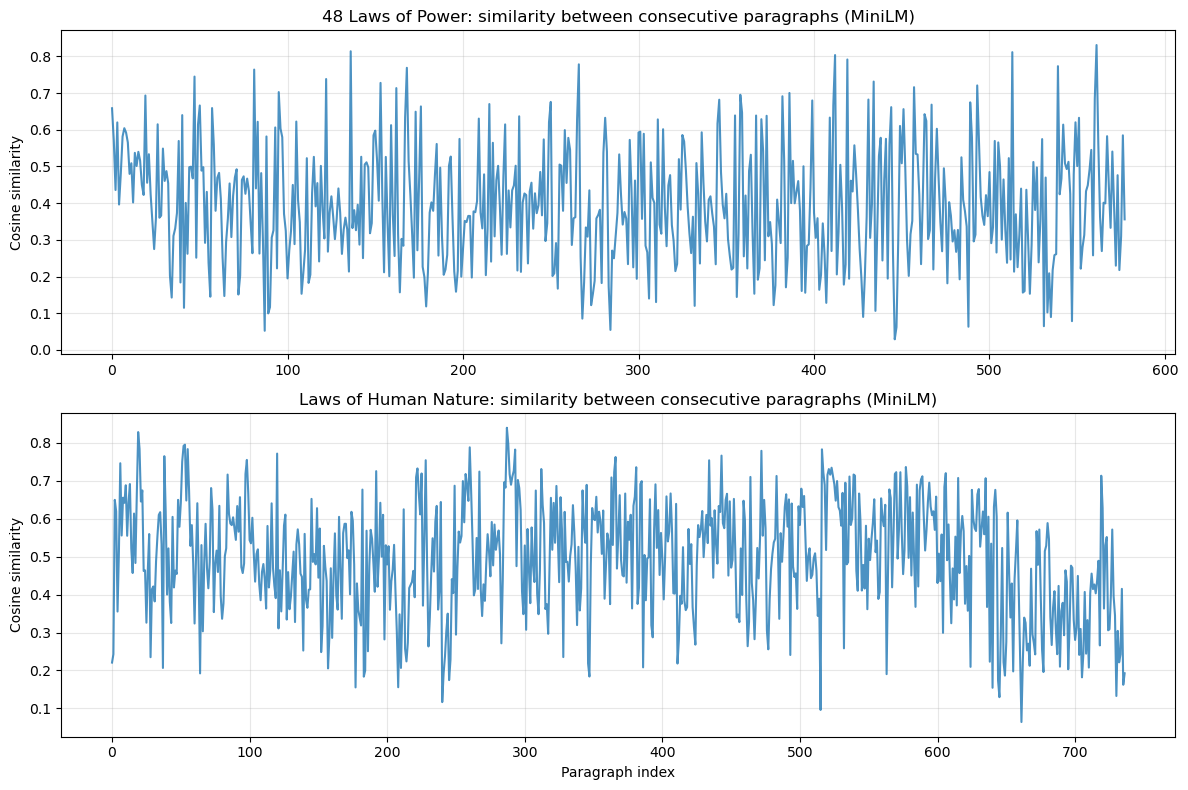

In [34]:
# Visualize topic drift as a line plot (similarity index)
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

# Plot for 48 Laws of Power
axes[0].plot(p_drift, alpha=0.8)
axes[0].set_title('48 Laws of Power: similarity between consecutive paragraphs (MiniLM)')
axes[0].set_ylabel('Cosine similarity')
axes[0].grid(True, alpha=0.3)

# Plot for Laws of Human Nature
axes[1].plot(h_drift, alpha=0.8)
axes[1].set_title('Laws of Human Nature: similarity between consecutive paragraphs (MiniLM)')
axes[1].set_xlabel('Paragraph index')
axes[1].set_ylabel('Cosine similarity')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


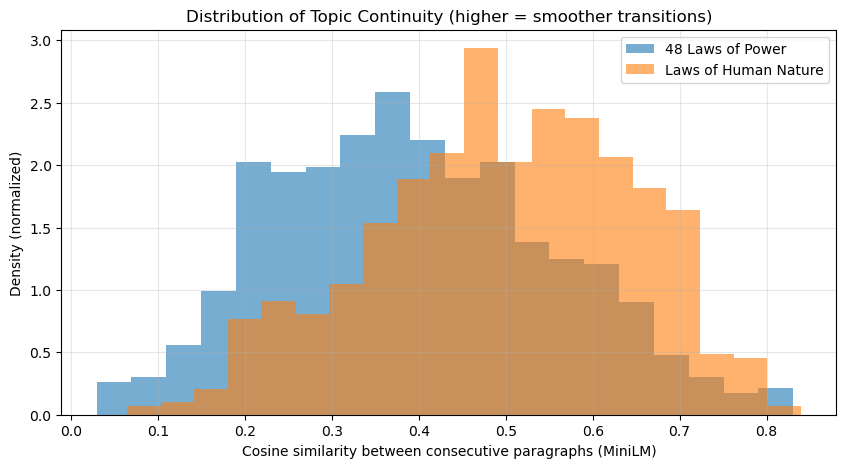

In [35]:
# Histogram comparison
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(p_drift, bins=20, alpha=0.6, label='48 Laws of Power', density=True)
ax.hist(h_drift, bins=20, alpha=0.6, label='Laws of Human Nature', density=True)
ax.set_xlabel('Cosine similarity between consecutive paragraphs (MiniLM)')
ax.set_ylabel('Density (normalized)')
ax.set_title('Distribution of Topic Continuity (higher = smoother transitions)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()


## Memory Cleanup

If you're running low on memory, run this cell to free up RAM by deleting large variables and clearing the model cache.

In [36]:
import gc

# Delete large variables to free memory
del power_text, human_text
del power_paras, human_paras
del p_drift, h_drift

# Clear matplotlib figures
plt.close('all')

# Unload the model from memory
del model

# Force garbage collection
gc.collect()

print("Memory cleaned! Large variables deleted and garbage collected.")

Memory cleaned! Large variables deleted and garbage collected.
